<a href="https://www.kaggle.com/code/gonzalogrecco144/mobile-price-first-project?scriptVersionId=103163363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

# DATA

In [2]:
train = pd.read_csv('../input/mobile-price-classification/train.csv')
test = pd.read_csv('../input/mobile-price-classification/test.csv')

print('train set shape: ',train.shape)
print('test set shape: ',test.shape)
train.head()

train set shape:  (2000, 21)
test set shape:  (1000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Train features description:
* **battery_power** -  Total energy a battery can store in one time measured in mAh
* **blue** - Has bluetooth or not
* **clock_speed** - speed at which microprocessor executes instructions
* **dual_sim** - Has dual sim support or not
* **fc** - Front Camera mega pixels
* **four_g** - Has 4G or not
* **int_memory** - Internal Memory in Gigabytes
* **m_dep** - Mobile Depth in cm
* **mobile_wt** - Weight of mobile phone
* **n_cores** - Number of cores of processor
* **pc** - Primary Camera mega pixels
* **px_height** - Pixel Resolution Height
* **px_width** - Pixel Resolution Width
* **ram** - Random Access Memory in Megabytes
* **sc_h** - Screen Height of mobile in cm
* **sc_w** - Screen Width of mobile in cm
* **talk_time** - longest time that a single battery charge will last when you are talking on the phone
* **three_g** - Has 3G or not
* **touch_screen** - Has touch screen or not
* **wifi** - Has wifi or not

### Target feature description:
* **price_range** - Phone price with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).

## Missing values

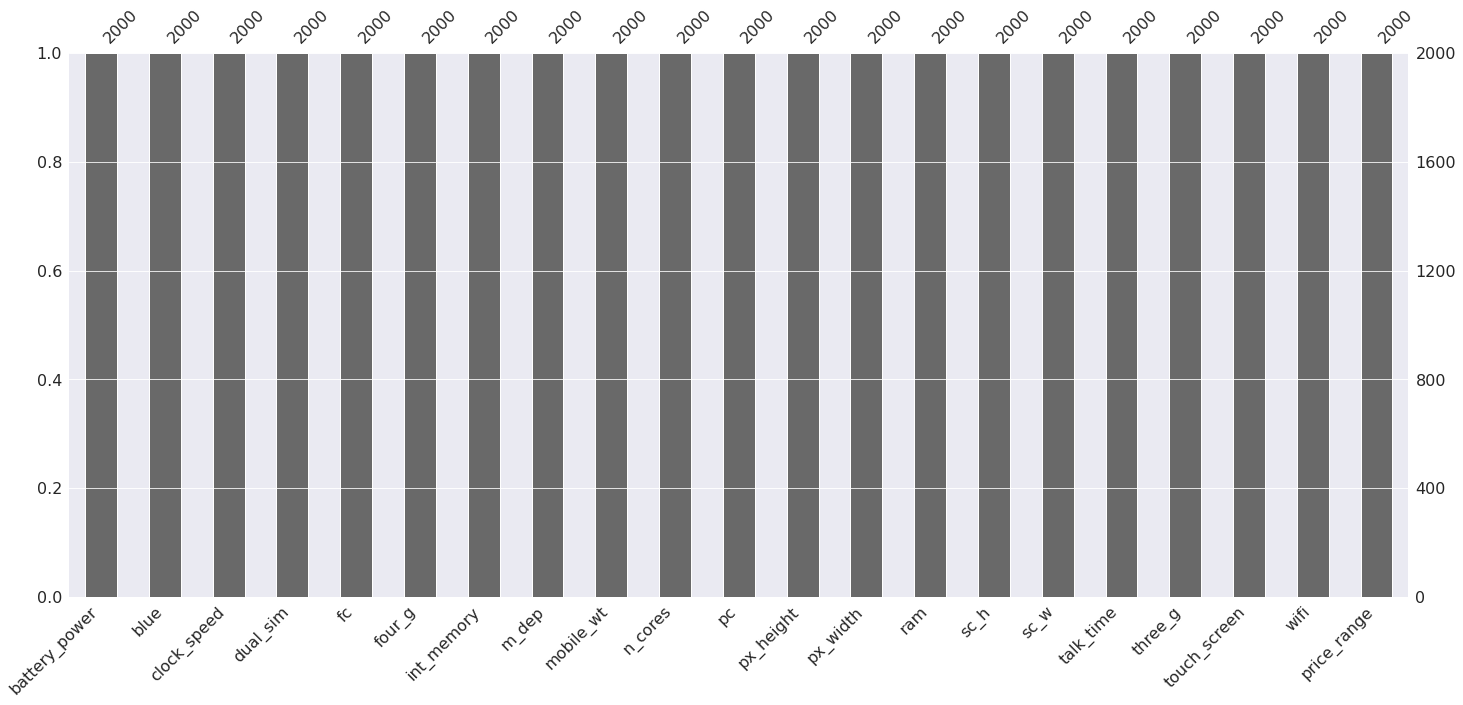

In [3]:
import missingno as msno
msno.bar(train)
plt.show()

#### • There is no missing values in any features.

## Duplicates

In [4]:
print(f'Duplicates in train data set: {train.duplicated().sum()} ({np.round(100*train.duplicated().sum()/len(train), 1)}%)')
print(f'Duplicated in test data set: {test.duplicated().sum()} ({np.round(100*test.duplicated().sum()/len(test), 1)}%)')

Duplicates in train data set: 0 (0.0%)
Duplicated in test data set: 0 (0.0%)


## Data types

#### • There are not object data so we don't have to worry about that for training the model

In [5]:
train.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

## Cardinality of features

#### • 18 discrete features and 2 continuous features (without the target feature)

In [6]:
train.nunique()

battery_power    1094
blue                2
clock_speed        26
dual_sim            2
fc                 20
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height        1137
px_width         1109
ram              1562
sc_h               15
sc_w               19
talk_time          19
three_g             2
touch_screen        2
wifi                2
price_range         4
dtype: int64

# EDA

## Target distribution

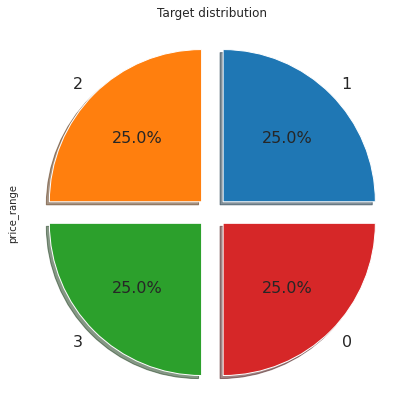

In [7]:
plt.figure(figsize=(7,7))
train['price_range'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title('Target distribution')
plt.show()

#### • The target is balanced, so we don't have to consider techniques like under/over-sampling.

## Correlation of each feature

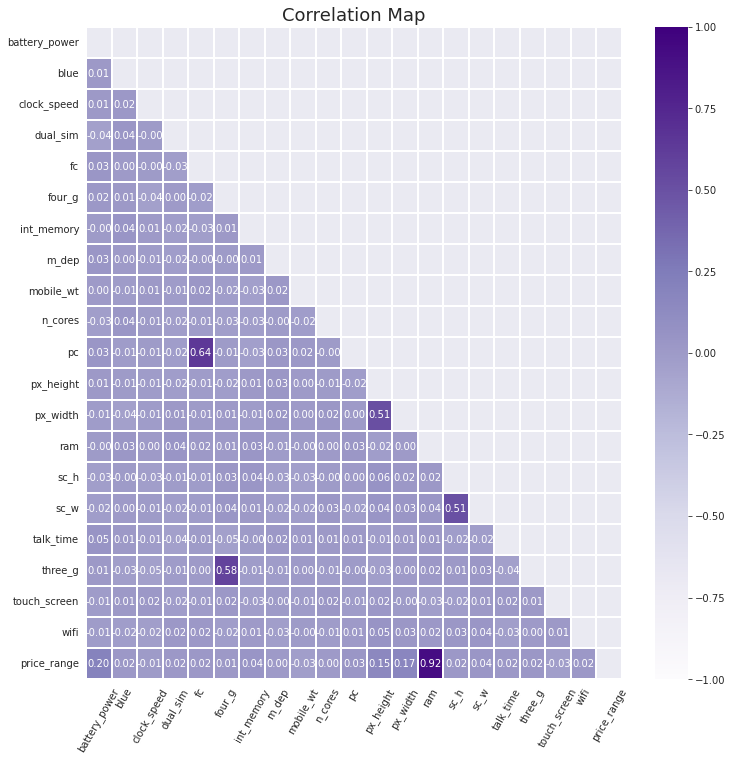

In [8]:
matrix = np.triu(train.corr())
fig = plt.subplots(figsize = (12,12))
sns.heatmap(train.corr(), annot= True, fmt = ".2f", vmax = 1, 
            mask = matrix, cmap = "Purples",vmin = -1, 
            linewidth = 0.2, linecolor = "white")
plt.xticks(rotation=60)
plt.title('Correlation Map', size = 18)
plt.show()

In [9]:
train.corr().sort_values(by=['price_range'], ascending=False).iloc[0].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

### How does ram is affected by price

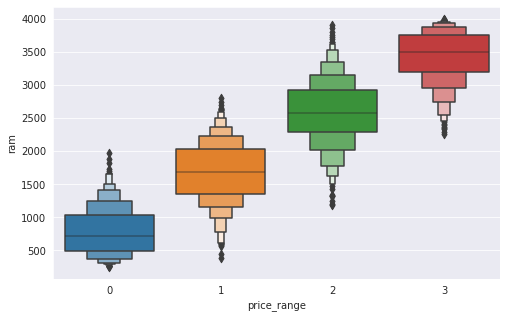

In [10]:
plt.figure(figsize=(8,5))
sns.boxenplot(y='ram',x='price_range',data=train)
plt.show()

###  Internal memory in gigabyte - ram and price range

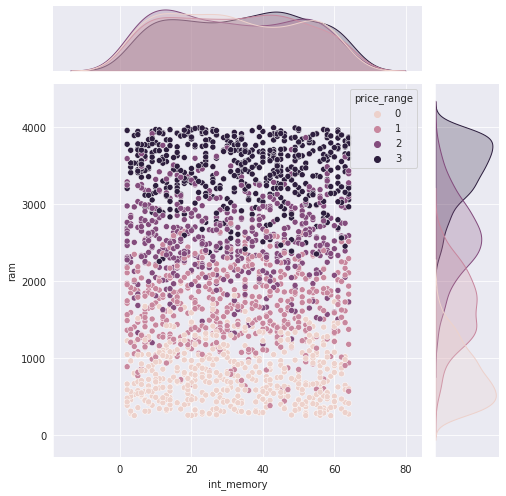

In [11]:
sns.jointplot(y='ram', x="int_memory", hue="price_range", data=train, height=7)
plt.show()

###  battery power - ram and price range

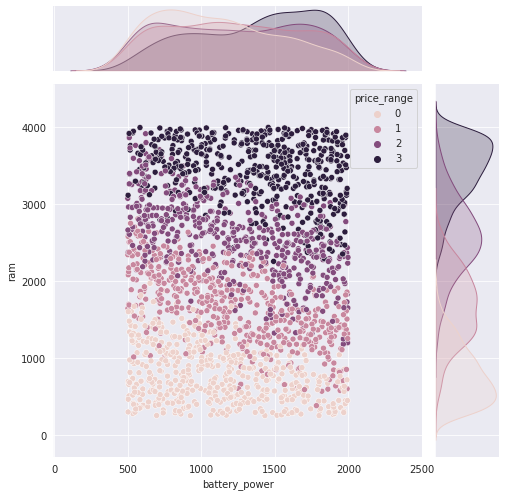

In [12]:
sns.jointplot(y='ram', x="battery_power", hue="price_range", data=train, height=7)
plt.show()

## Discrete features (most categorical)

### 3G, 4G, bluetooth, WiFi, touch_screen and dual_sim

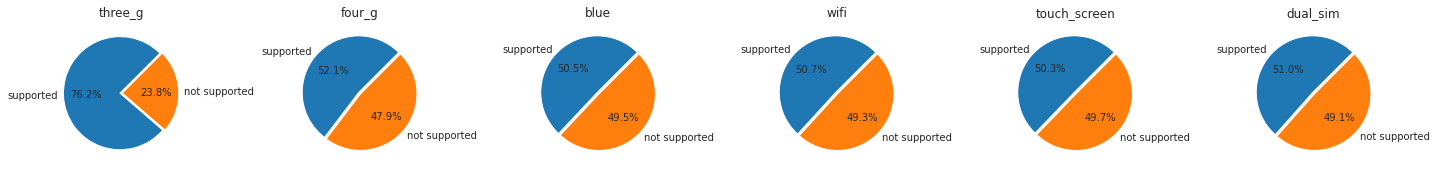

In [13]:
labels = ['supported', 'not supported']
features = ['three_g', 'four_g', 'blue', 'wifi', 'touch_screen', 'dual_sim']
i = 1
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(features):
    ax = fig.add_subplot(1,6,i+1)
    ax.pie(train[feature].value_counts().values, labels=labels, autopct='%1.1f%%', startangle=45, explode=[0.02, 0.02])
    ax.set_title(feature)
fig.tight_layout()
plt.show()

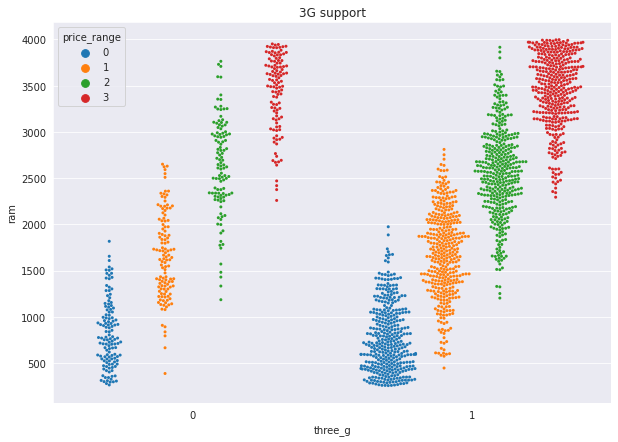

In [14]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='three_g', y='ram', hue='price_range', data=train, dodge=True, size=3).set_title('3G support')
plt.show()

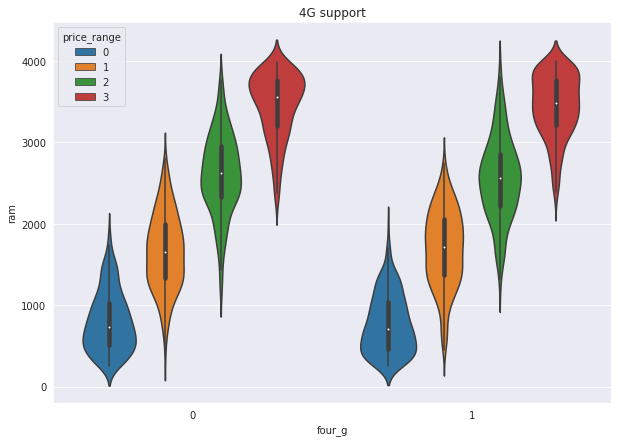

In [15]:
plt.figure(figsize=(10,7))
sns.violinplot(x='four_g', y='ram', hue='price_range', data=train, dodge=True).set_title('4G support')
plt.show()

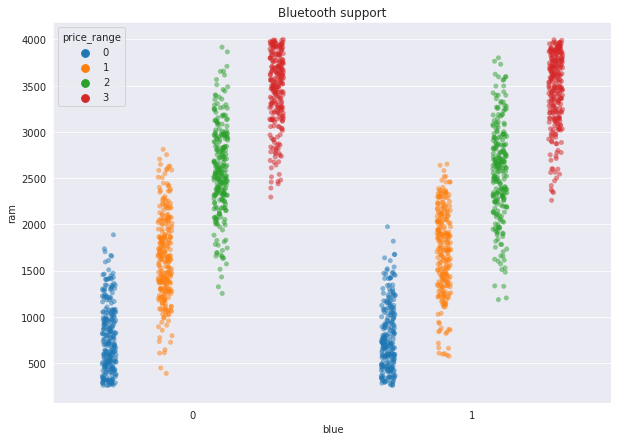

In [16]:
plt.figure(figsize=(10,7))
sns.stripplot(x='blue', y='ram', hue='price_range', data=train, dodge=True, jitter=True, alpha=.5).set_title('Bluetooth support')
plt.show()

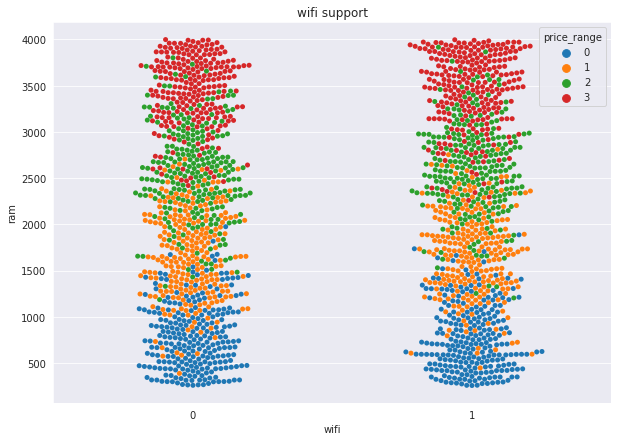

In [17]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='wifi', y='ram', hue='price_range', data=train).set_title('wifi support')
plt.show()

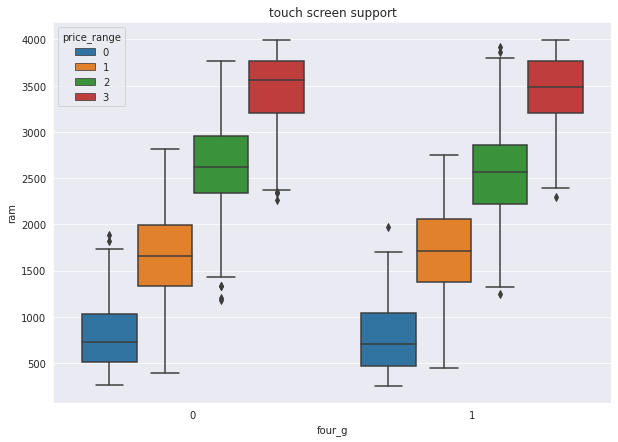

In [18]:
plt.figure(figsize=(10,7))
sns.boxplot(x='four_g', y='ram', hue='price_range', data=train, dodge=True).set_title('touch screen support')
plt.show()

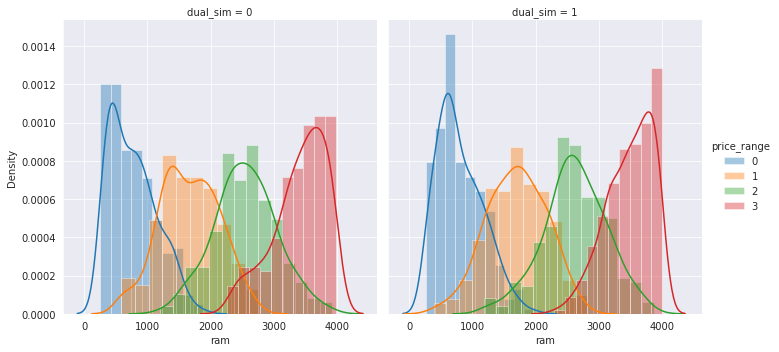

In [19]:
g = sns.FacetGrid(train, col='dual_sim', hue='price_range', height=5)
g = (g.map(sns.distplot, 'ram').add_legend())

# Preprocessing

## Normalize the data and prepare the train_test_split for the differents models

In [20]:
y = train["price_range"].values
x = train.drop(["price_range"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Model selection

## Logistic regression

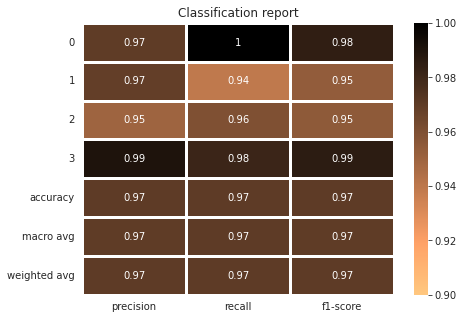

In [22]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
cr = classification_report(y_test, y_pred, output_dict=True)
cr_df = pd.DataFrame(cr)
fig = plt.subplots(figsize=(7, 5))
sns.heatmap(cr_df.iloc[:-1, :].T, annot=True, vmin=0.9, cmap='copper_r', linewidth=3)
plt.title('Classification report')
plt.show()

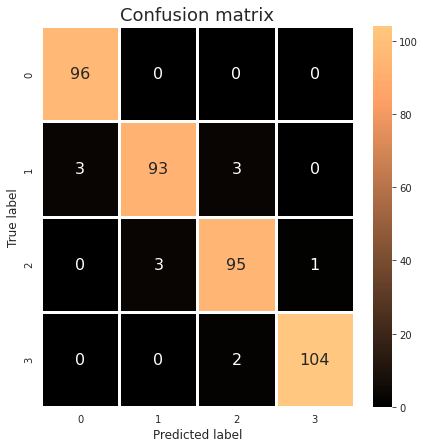

In [23]:
cm = confusion_matrix(y_test, y_pred)
fig = plt.subplots(figsize=(7, 7))
df1 = pd.DataFrame(columns=['0', '1', '2', '3'], index=['0', '1', '2', '3'], data=cm)
sns.heatmap(df1, cmap='copper', annot=True, annot_kws={'size':16}, fmt='.0f', linewidth=3)
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('Confusion matrix', size=18)
plt.show()

## GridSearchCV

In [24]:
logreg = LogisticRegression()
logreg_param_grid = {'C': np.logspace(-4, 4, 18),
                     'penalty': ['l1', 'l2']}
lm = GridSearchCV(logreg,
                 param_grid = logreg_param_grid,
                 cv = StratifiedKFold(n_splits = 10),
                 scoring = 'accuracy')

lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
y_proba = lm.predict_proba(x_test)

print('Model : {}'.format(logreg))
print('Accuracy : % {}'.format(round(lm.best_score_*100, 2)))
print('MSE : {}'.format(mean_squared_error(y_test, y_pred)))
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_proba, multi_class='ovr')))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='weighted')))
print('F1-score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Best estimator: {}'.format(lm.best_estimator_))

Model : LogisticRegression()
Accuracy : % 97.31
MSE : 0.03
ROC AUC: 0.9990259567633231
Recall: 0.97
Precision: 0.9700506960516165
F1-score: 0.9700010836042969
Best estimator: LogisticRegression(C=15.013107289081743)


## Best estimator

In [25]:
logreg = LogisticRegression(C=15.013107289081743)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(logreg.score(x_test, y_test))
print(classification_report(y_test, y_pred))

0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        96
           1       0.96      0.95      0.95        99
           2       0.95      0.96      0.95        99
           3       0.99      0.98      0.99       106

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



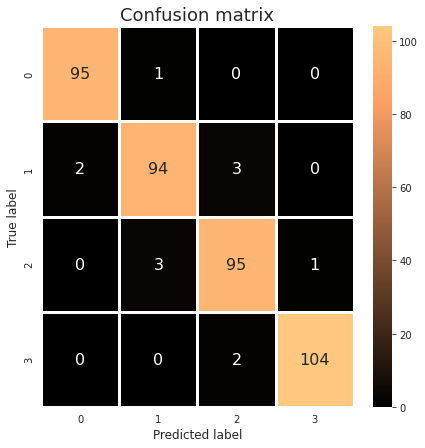

In [26]:
cm = confusion_matrix(y_test, y_pred)
fig = plt.subplots(figsize=(7, 7))
df1 = pd.DataFrame(columns=['0', '1', '2', '3'], index=['0', '1', '2', '3'], data=cm)
sns.heatmap(df1, cmap='copper', annot=True, annot_kws={'size':16}, fmt='.0f', linewidth=3)
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('Confusion matrix', size=18)
plt.show()

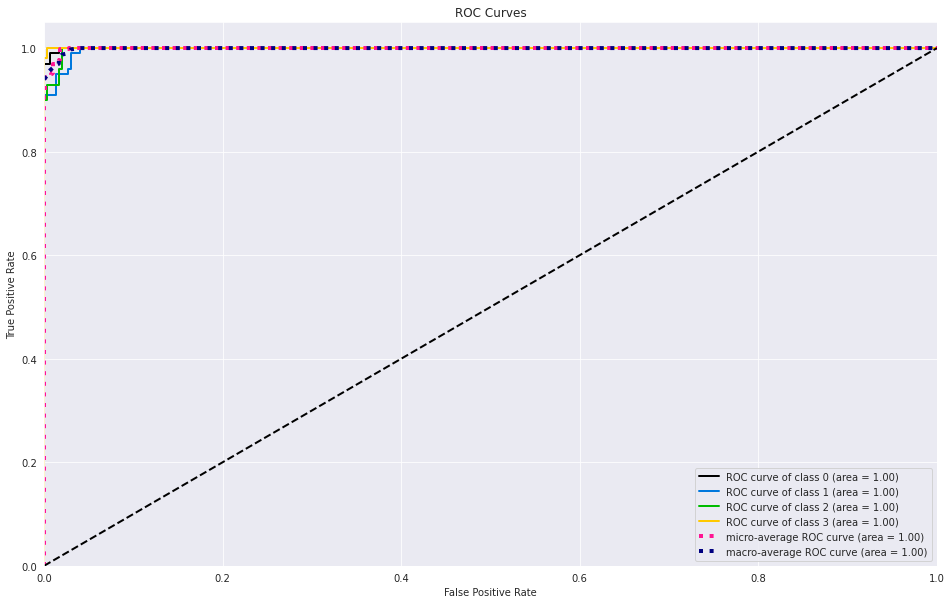

In [27]:
import scikitplot as skplt

y_proba = logreg.predict_proba(x_test)
skplt.metrics.plot_roc(y_test, y_proba, figsize=(16,10))
plt.show()